In [17]:
# %matplotlib ipympl
# %matplotlib notebook
# %matplotlib widget
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import sys
import cv2
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import impyute as impy
import tensorflow as tf

from ai_badminton.trajectory import Trajectory
from ai_badminton.hit_detector import AdhocHitDetector, MLHitDetector
from ai_badminton.pose import Pose, read_player_poses, process_pose_file
from ai_badminton.court import Court, read_court
from ai_badminton.video_annotator import annotate_video

In [23]:
# Import shuttle trajectories and poses
root_name = 'anthony-ginting-beat-kento-momota-anthony-ginting-vs-kento-momota-fo-2019-hlzrivktbyo'

# Get poses and trajectories
trajectory = Trajectory('./data/%s_predict.csv' % root_name)

# Get video
cap = cv2.VideoCapture('./data/%s.mp4' % root_name)
if cap.isOpened() is False:
    print('Error opening video stream or file')

fps = cap.get(cv2.CAP_PROP_FPS)

In [24]:
# Some outlier detection programs
# from sklearn.ensemble import IsolationForest

# outliers_fraction = 0.05
# model =  IsolationForest(contamination=outliers_fraction)
# model.fit(trajectory.Y_pred.values.reshape(-1, 1)) 
# trajectory['anomaly_Y'] = pd.Series(model.predict(trajectory.Y_pred.values.reshape(-1, 1)))

# # visualization
# trajectory['anomaly_Y'] = pd.Series(trajectory['anomaly_Y'].values, index=trajectory.index)
# a = trajectory.loc[trajectory['anomaly_Y'] == -1] #anomaly
# _ = plt.figure(figsize=(18,6))
# _ = plt.plot(trajectory['Y_pred'], color='blue', label='Normal')
# _ = plt.plot(a['Y_pred'], linestyle='none', marker='X', color='red', markersize=12, label='Anomaly')
# plt.show()

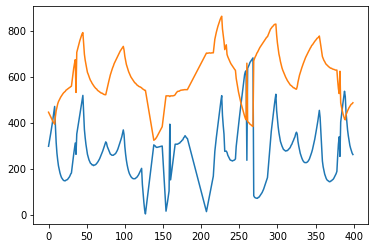

In [25]:
plt.plot(range(400), trajectory.Y[:400])
plt.plot(range(400), trajectory.X[:400])
plt.show()

In [26]:
court = Court(
    read_court('./data/%s_court.out' % root_name)
)

In [27]:
# If pose files are not yet processed, do this:
poses = process_pose_file(
    './data/%s_poses_mmpose.out' % root_name, 
    './output/%s' % root_name, 
    court,
    fullPose=True
)

Read in files. Processing poses...


  0%|          | 0/4499129 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!


In [28]:
poses = read_player_poses('./output/%s' % root_name)

Total shots hit by players: 301
Total impacts detected: 413
Distribution of shot times:
Average time between shots (s): 1.2485436893203883


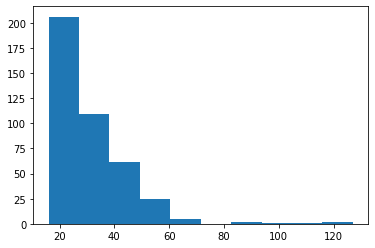

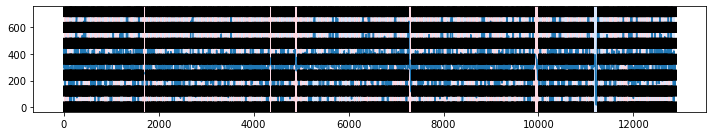

In [29]:
import ruptures as rpt

# signal
signal_x = np.array(trajectory.X)
signal_y = np.array(trajectory.Y)

# detection
detector = AdhocHitDetector(poses, trajectory)
result, is_hit = detector.detect_hits(fps)

# display
rpt.display(signal_y, result, result)
plt.show()

In [30]:
# New hit detection
os.chdir('/home/code-base/user_space/ai-badminton/notebooks')

In [31]:
detector = MLHitDetector(
    court,
    poses,
    trajectory,
    './../TrackNetv2/3_in_3_out/hitnet_conv_model_predict_player_and_hit_big_augmentation_new_poses.h5'
)

Number of layers: 16
Total params: 17968
Trainable params: 17968
Non-trainable params: 0


Sum of predicted scores: [9466.597    1627.5205   1666.5562    109.316475]
Total shots hit by players:
Percentage of shots hit by player 1: 0.5430809399477807
Total impacts detected: 428
Distribution of shot times:
Average time between shots (s): 1.2052459016393442


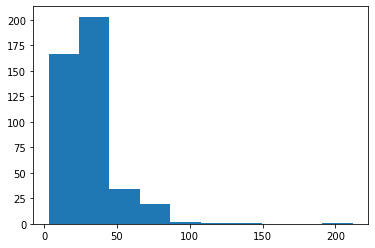

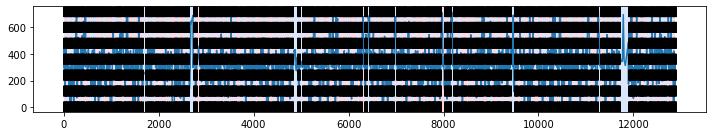

In [32]:
result, is_hit = detector.detect_hits(fps)
rpt.display(signal_y, result, result)
plt.show()

In [33]:
annotate_video(
    cap,
    court,
    poses,
    trajectory,
    result,
    is_hit,
    frame_limit=4020
)

  0%|          | 0/4020 [00:00<?, ?it/s]

In [17]:
from IPython.display import HTML

HTML("""
    <video alt="test" width="780" controls>
        <source src="./output/output.mp4" type="video/mp4">
    </video>
""")

In [35]:
# Find sequences of fully formed rallies
started = False
spos, lpid = 0, 0
num_rallies, rally_len = 0, 0
rallies = []
for i, pid in enumerate(is_hit):
    if pid > 0 and not started:
        # Start the chain
        spos, lpid = i, pid
        started = True
        rally_len = 1
    elif started:
        if pid == 0:
            started = False
            if rally_len >= 2:
                print('Rally length:', rally_len)
                rallies.append([result[spos], result[i]])
        elif pid == lpid:
            rally_len = 0
            spos = i
        else:
            lpid = pid
            rally_len += 1
            
print(len(rallies))

Rally length: 7
Rally length: 10
Rally length: 14
Rally length: 2
Rally length: 3
Rally length: 7
Rally length: 2
Rally length: 5
Rally length: 6
Rally length: 6
Rally length: 3
Rally length: 4
Rally length: 3
Rally length: 9
Rally length: 2
Rally length: 14
Rally length: 8
Rally length: 6
Rally length: 2
Rally length: 4
Rally length: 3
Rally length: 2
Rally length: 4
Rally length: 2
Rally length: 2
Rally length: 2
Rally length: 22
Rally length: 5
Rally length: 3
Rally length: 11
Rally length: 2
Rally length: 2
32


In [36]:
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))   # float `width`
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))  # float `height`
    
for rid, rally in enumerate(rallies):
    print('Processing rally', rid)
    print('Rally duration', (rally[1] - rally[0]) / fps)
    cap.set(cv2.CAP_PROP_POS_FRAMES, rally[0])
    outvid = cv2.VideoWriter(
        './output/rallies/' + str(rid) + '.mp4', 
        cv2.VideoWriter_fourcc('M','P','4','V'), 
        fps, 
        (width, height)
    )

    for i in range(rally[0], rally[1]+10):
        ret, frame = cap.read()
        outvid.write(frame)
    outvid.release()

Processing rally 0
Rally duration 6.36
Processing rally 1
Rally duration 7.6
Processing rally 2
Rally duration 14.0
Processing rally 3
Rally duration 2.64
Processing rally 4
Rally duration 3.84
Processing rally 5
Rally duration 8.08
Processing rally 6
Rally duration 2.4
Processing rally 7
Rally duration 6.4
Processing rally 8
Rally duration 6.56
Processing rally 9
Rally duration 7.76
Processing rally 10
Rally duration 2.4
Processing rally 11
Rally duration 5.04
Processing rally 12
Rally duration 3.32
Processing rally 13
Rally duration 9.84
Processing rally 14
Rally duration 1.28
Processing rally 15
Rally duration 15.6
Processing rally 16
Rally duration 8.56
Processing rally 17
Rally duration 6.8
Processing rally 18
Rally duration 3.28
Processing rally 19
Rally duration 4.04
Processing rally 20
Rally duration 2.72
Processing rally 21
Rally duration 2.04
Processing rally 22
Rally duration 2.72
Processing rally 23
Rally duration 2.88
Processing rally 24
Rally duration 1.72
Processing rall

In [125]:
os.getcwd()

'/trainman-mount/trainman-k8s-storage-6677a55e-8792-44ee-923d-9ed5edea05ca/ai-badminton/notebooks'